# Analiza porównawcza metod klasteryzacji i segmentacji obrazów
## K-means, DBSCAN, Watershed i CNN na Oxford Pet Dataset

W niniejszym notatniku porównane zostaną metody klasteryzacji (K-means, DBSCAN) i segmentacji (Watershed, CNN) na zbiorze danych Oxford Pet Dataset. Celem jest ocena skuteczności oraz jakości różnych podejść do segmentacji obrazów w kontekście rozpoznawania kształtów i konturów obiektów.


In [ ]:
# Biblioteki
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from PIL import Image

#test comment

# Sklearn i Scipy
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy import ndimage as ndi

# Watershed
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import sobel

# TensorFlow / PyTorch (CNN)
import tensorflow as tf
from tensorflow.keras import layers, models

# Wyświetlanie w notatniku
%matplotlib inline


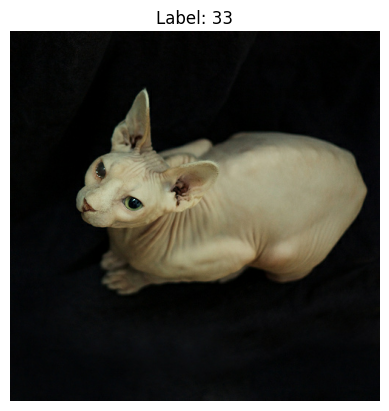

In [ ]:
# Pobieranie danych
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=True)
label_names = info.features['label'].names
train_data, test_data = dataset['train'], dataset['test']

# Przykładowa wizualizacja
for image, label in train_data.take(1):
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()


In [ ]:
for img, lbl in train_data.take(1):
    print("Image shape:", img.shape)
    print("Label:", lbl)

Image shape: (500, 500, 3)
Label: tf.Tensor(33, shape=(), dtype=int64)


In [ ]:
# Nadanie labeli
cat_breeds = [
    'Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair',
    'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue',
    'Siamese', 'Sphynx'
]

dog_breeds = [
    'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle',
    'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired',
    'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher',
    'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier',
    'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier'
]

label_to_class = {}

for i, name in enumerate(label_names):
    if name in cat_breeds:
        label_to_class[i] = 0  # 0 = Cat
    elif name in dog_breeds:
        label_to_class[i] = 1  # 1 = Dog


def binary_label_map(label):
    return tf.cast(label_to_class[int(label.numpy())], tf.int64)

In [ ]:
# Wstepne przetwarzanie danych

IMG_SIZE = 128

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0

    label = tf.py_function(func=binary_label_map, inp=[label], Tout=tf.int64)
    label = tf.cast(label, tf.int64)  # Skalarny tensor (int)
    return image, label


train_data_bin = train_data.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

# Przykłady segmentacji na różnych podzbiorach


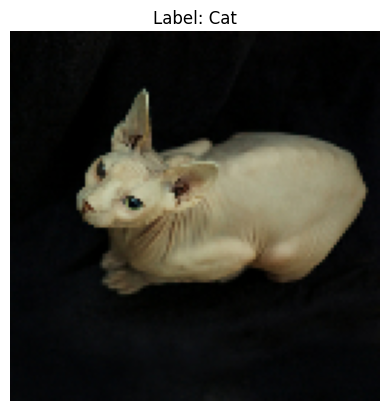

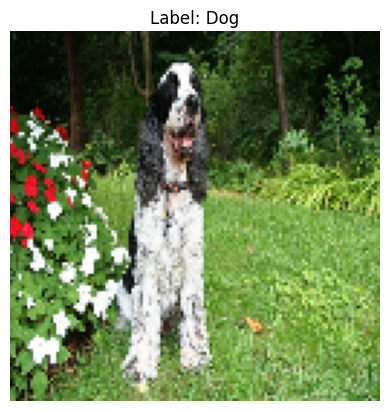

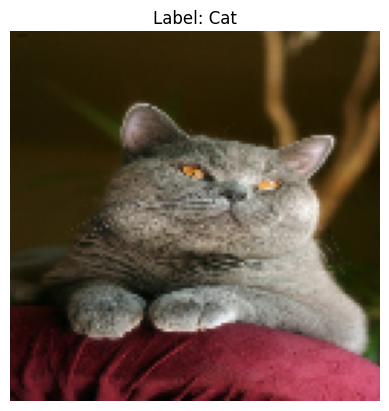

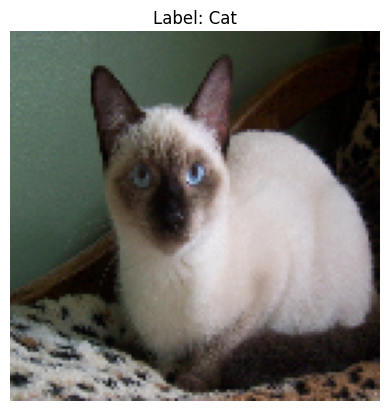

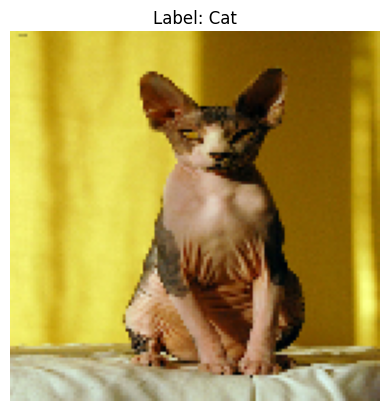

In [ ]:
# Przykładowa wizualizacja z labelami
for images, labels in train_data_bin.take(1):
    for i in range(5):
        plt.imshow(images[i].numpy())
        plt.title("Label: " + ("Cat" if labels[i].numpy() == 0 else "Dog"))
        plt.axis("off")
        plt.show()

In [ ]:
def knn_segmentation(image, sample_ratio=0.01, n_neighbors=5):
    print(f"Kształt obrazu przed: {image.shape}")

    img = (image.numpy() * 255).astype(np.uint8)

    # Sprawdzamy, czy obraz jest w kolorze (3 kanały), czy w skali szarości (1 kanał)
    if len(img.shape) == 3:
        # Konwersja na skale szarości (jeśli obraz ma 3 kanały)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    print(f"Kształt obrazu po konwersji na szarość: {img.shape}")

    h, w = img.shape  # Teraz mamy tylko dwa wymiary (wysokość i szerokość)
    pixels = img.reshape(-1, 1).astype(np.float32)

    n_samples = int(len(pixels) * sample_ratio)
    indices = np.random.choice(len(pixels), n_samples, replace=False)
    train_pixels = pixels[indices]

    # Inicjalizacja KMeans
    kmeans = KMeans(n_clusters=3, random_state=0)

    try:
        # Trening KMeans na wybranych próbkach
        kmeans.fit(train_pixels)
    except Exception as e:
        print(f"Błąd przy dopasowywaniu KMeans: {e}")
        return None

    # Segmentacja wyników
    labels_pred = kmeans.predict(pixels)
    segmented_img = kmeans.cluster_centers_[labels_pred]

    segmented_img = segmented_img.reshape(h, w) / 255.0  # Skala [0, 1] do wyświetlenia

    return segmented_img

Kształt obrazu przed: (500, 3)
Kształt obrazu po konwersji na szarość: (500, 3)


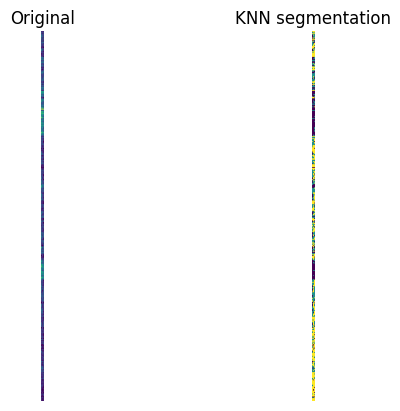

In [ ]:
for batch in train_data.take(1):
    img = batch[0][0]
    result = knn_segmentation(img)
    plt.subplot(1, 2, 1)
    plt.imshow(img.numpy())
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.title("KNN segmentation")
    plt.axis('off')
    plt.show()

In [ ]:
def kmeans_segmentation(image):
    img = np.array(image)
    pixel_values = img.reshape((-1, 3))
    kmeans = KMeans(n_clusters=3, random_state=0).fit(pixel_values)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_img = segmented_img.reshape(img.shape)
    return segmented_img.astype(np.uint8)

# Test
for image, _ in train_data.take(1):
    img = image[0].numpy()
    result = kmeans_segmentation(img)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.title("K-means")
    plt.axis('off')
    plt.show()


In [ ]:
def dbscan_segmentation(image):
    img = np.array(image)
    pixel_values = img.reshape((-1, 3))
    pixel_values = StandardScaler().fit_transform(pixel_values)
    db = DBSCAN(eps=0.5, min_samples=50).fit(pixel_values)
    labels = db.labels_.reshape(image.shape[:2])
    return labels

# Test
for image, _ in train_data.take(1):
    img = image[0].numpy()
    labels = dbscan_segmentation(img)
    plt.imshow(labels, cmap='jet')
    plt.title("DBSCAN")
    plt.axis('off')
    plt.show()


In [ ]:
def watershed_segmentation(image):
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    gradient = sobel(gray)
    markers = ndi.label(gradient < 0.1)[0]
    labels = watershed(gradient, markers)
    return labels

# Test
for image, _ in train_data.take(1):
    img = image[0].numpy()
    result = watershed_segmentation(img)
    plt.imshow(result, cmap='nipy_spectral')
    plt.title("Watershed")
    plt.axis('off')
    plt.show()


In [ ]:
def get_simple_cnn(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
        layers.Conv2D(1, 1, activation='sigmoid')
    ])
    return model

# Model
model = get_simple_cnn((IMG_SIZE, IMG_SIZE, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# (Tutaj mock treningu)
# model.fit(train_data, epochs=5)


In [ ]:
# Tabelka z czasem działania
# Wizualizacja wyników

# Porownanie i Ocena Metod

# Wnioski

# Dalsze kierunki